# Petfinder Adoption Prediction


Author: Dawid Wisniewski

Project description and data: https://www.kaggle.com/c/petfinder-adoption-prediction

## Data imports

#### Download all data from kaggle

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import pandas as pd
import numpy as np

In [2]:
# Get current dir

current_dir = os.getcwd()
data_dir = current_dir+r'/Data'
data_dir

'/home/dawid/Python/Kodolamacz/Projekt/pet_adoption/Data'

In [17]:
competition_name = 'petfinder-adoption-prediction'

kaggle_api = KaggleApi()
kaggle_api.authenticate()
kaggle.api.competition_download_files(competition_name, path=data_dir)

In [20]:
data_zip_file = f'{data_dir}/{competition_name}.zip'

with zipfile.ZipFile(data_zip_file, 'r') as zipref:
    zipref.extractall(data_dir)

In [23]:
os.remove(data_zip_file) 

#### Review the tabularized data

In [3]:
data = pd.read_csv('Data/train/train.csv')
data.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [16]:
data

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,266,0,3,1,0,0,2,...,1,4,0,41326,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3.0,2
14989,2,Serato & Eddie,60,265,264,3,1,4,7,2,...,1,2,0,41326,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3.0,4
14990,2,Monkies,2,265,266,3,5,6,7,3,...,1,5,30,41326,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5.0,3
14991,2,Ms Daym,9,266,0,2,4,7,0,1,...,1,1,0,41336,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3.0,4


In [20]:
data.dtypes

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object

#### Investigate photo description from Google Natural Language API in the json files

In [20]:
data[data.PetID=='0a0e8c15b'].Description

5290    Fenny was rescued from Old Klang Rd market whe...
Name: Description, dtype: object

In [7]:
# Let's see how the json files with sentiment is structured

with open('Data/train_sentiment/0a0e8c15b.json') as json_file:
    sentiment_file = json.load(json_file)
    
sentiment_file

{'sentences': [{'text': {'content': 'Fenny was rescued from Old Klang Rd market when she was only 2 months old and I have fostered her since then.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0.1, 'score': -0.1}},
  {'text': {'content': 'She is 5 mths old now and I hope she can get a good home.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0.7, 'score': 0.7}},
  {'text': {'content': 'She looks like a mixed breed of local mongrel and Dalmation.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0.1, 'score': 0.1}},
  {'text': {'content': 'She is a very quiet girl and does not make too much noise, that makes her a very good companion for children or elderly couple.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0.9, 'score': 0.9}},
  {'text': {'content': 'Please call Mrs Lai of Paws Mission for more adoption details.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0, 'score': 0}}],
 'tokens': [],
 'entities': [{'name': 'Fenny',
   'type': 'PERSO

* As minimum we will use the overal 'documentSentiment' considering the score, the magnitude or mix of both 
(consider finding minimum thresholds for positive and nevative scores)
* Furthermore let's see how the results per sentence looks like, and if it is potentially also worth adding

In [17]:
for sentence in sentiment_file['sentences']:
    print(sentence['sentiment'])
# at sentence level it seems that absolute value of score is the same as magnitude, 
# so it's only useful to track score

{'magnitude': 0.4, 'score': 0.4}
{'magnitude': 0.5, 'score': 0.5}
{'magnitude': 0.1, 'score': -0.1}


In [28]:
sentence_data=[]
missing_files = 0
for file in data.PetID:
    try:
        with open(f'Data/train_sentiment/{file}.json') as json_file:
            sentiment_file = json.load(json_file)

        sentiment = sentiment_file['documentSentiment']['score']
        magnitude = sentiment_file['documentSentiment']['magnitude']
        combined_sentiment = sentiment * magnitude

        sentence_scores = [sentence['sentiment']['score'] for sentence in sentiment_file['sentences']]
        number_of_sentences = len(sentence_scores)

        avg_sentence_score = np.mean(sentence_scores)
        min_sentence_score = np.min(sentence_scores)
        max_sentence_score = np.max(sentence_scores)

        sentence_data.append([file, sentiment, magnitude, combined_sentiment, 
                             number_of_sentences, avg_sentence_score, min_sentence_score, max_sentence_score])

    except:
        missing_files += 1
    
sentence_data = pd.DataFrame(sentence_data, columns=['PetID', 'sentiment', 'magnitude', 'combined_sentiment', 
                         'number_of_sentences', 'avg_sentence_score', 'min_sentence_score', 'max_sentence_score'])

if missing_files:
    print(f'Sentiment files for {missing_files} pets was missing')

Sentiment files for 551 pets was missing


In [19]:
sentence_data

,PetID,sentiment,magnitude,combined_sentiment,number_of_sentences,avg_sentence_score,min_sentence_score,max_sentence_score
0,86e1089a3,0.3,2.4,0.72,6,0.300000,-0.2,0.8
1,6296e909a,-0.2,0.7,-0.14,2,-0.250000,-0.6,0.1
2,3422e4906,0.2,3.7,0.74,7,0.200000,-0.9,0.9
3,5842f1ff5,0.9,0.9,0.81,1,0.900000,0.9,0.9
4,850a43f90,0.6,3.7,2.22,6,0.583333,0.0,0.8
...,...,...,...,...,...,...,...,...
14988,dc0935a84,0.4,2.5,1.00,6,0.400000,0.0,0.9
14989,a01ab5b30,0.0,0.3,0.00,3,0.100000,0.0,0.2
14990,d981b6395,0.8,2.5,2.00,3,0.833333,0.7,0.9
14991,e4da1c9e4,0.9,0.9,0.81,1,0.900000,0.9,0.9


In [23]:
data_enriched = data.merge(sentence_data, how='left', on='PetID')
data_enriched

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,PetID,PhotoAmt,AdoptionSpeed,sentiment,magnitude,combined_sentiment,number_of_sentences,avg_sentence_score,min_sentence_score,max_sentence_score
0,2,Nibble,3,299,0,1,1,7,0,1,...,86e1089a3,1.0,2,0.3,2.4,0.72,6,0.300000,-0.2,0.8
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,6296e909a,2.0,0,-0.2,0.7,-0.14,2,-0.250000,-0.6,0.1
2,1,Brisco,1,307,0,1,2,7,0,2,...,3422e4906,7.0,3,0.2,3.7,0.74,7,0.200000,-0.9,0.9
3,1,Miko,4,307,0,2,1,2,0,2,...,5842f1ff5,8.0,2,0.9,0.9,0.81,1,0.900000,0.9,0.9
4,1,Hunter,1,307,0,1,1,0,0,2,...,850a43f90,3.0,2,0.6,3.7,2.22,6,0.583333,0.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,266,0,3,1,0,0,2,...,dc0935a84,3.0,2,0.4,2.5,1.00,6,0.400000,0.0,0.9
14989,2,Serato & Eddie,60,265,264,3,1,4,7,2,...,a01ab5b30,3.0,4,0.0,0.3,0.00,3,0.100000,0.0,0.2
14990,2,Monkies,2,265,266,3,5,6,7,3,...,d981b6395,5.0,3,0.8,2.5,2.00,3,0.833333,0.7,0.9
14991,2,Ms Daym,9,266,0,2,4,7,0,1,...,e4da1c9e4,3.0,4,0.9,0.9,0.81,1,0.900000,0.9,0.9


#### Investigate photo description from Google Vision in the json files

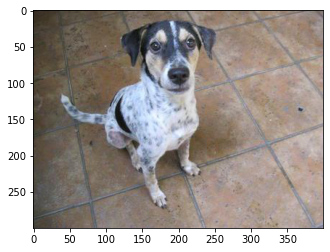

In [14]:
img = mpimg.imread('Data/train_images/0a0e8c15b-1.jpg')
imgplot = plt.imshow(img)
plt.show()

In [10]:
with open('Data/train_metadata/0a0e8c15b-1.json') as json_file:
    data = json.load(json_file)
    
data

{'labelAnnotations': [{'mid': '/m/0kpmf',
   'description': 'dog breed',
   'score': 0.94287944,
   'topicality': 0.94287944},
  {'mid': '/m/0bt9lr',
   'description': 'dog',
   'score': 0.9390443,
   'topicality': 0.9390443},
  {'mid': '/m/01z5f',
   'description': 'dog like mammal',
   'score': 0.85380834,
   'topicality': 0.85380834},
  {'mid': '/m/0ysvz',
   'description': 'louisiana catahoula leopard dog',
   'score': 0.8262601,
   'topicality': 0.8262601},
  {'mid': '/m/05zmzn1',
   'description': 'street dog',
   'score': 0.79076236,
   'topicality': 0.79076236},
  {'mid': '/m/02xl47d',
   'description': 'dog breed group',
   'score': 0.6743105,
   'topicality': 0.6743105},
  {'mid': '/m/08c5h8',
   'description': 'brazilian terrier',
   'score': 0.6140104,
   'topicality': 0.6140104},
  {'mid': '/m/0bh41s',
   'description': 'feist',
   'score': 0.59842026,
   'topicality': 0.59842026},
  {'mid': '/m/01lrl',
   'description': 'carnivoran',
   'score': 0.5740566,
   'topicality'

* Cpnsider using similarity to other dog breeds (identified by Google's Vision might be useful on top of the actual breed)
* Consider using Dominant colors might also have impact on AdoptionSpeed

In [37]:
#the code below combines data only for the profile picture, metadata for other pictures is ignored

metadata_data=[]
missing_files = 0

for file in data.PetID:
    try:
        with open(f'Data/train_metadata/{file}-1.json') as json_file:
            metadata_file = json.load(json_file)

        potential_breeds = [element['description'] for element in metadata_file['labelAnnotations']]
        potential_breeds_similarity = [element['score'] for element in metadata_file['labelAnnotations']]

        # add processing potential breeds here

        
        dominant_colors = [color['color'] for color in metadata_file['imagePropertiesAnnotation']['dominantColors']['colors']]
        dominant_colors_share = [color['pixelFraction'] for color in metadata_file['imagePropertiesAnnotation']['dominantColors']['colors']]

        # add processing colors here

        
        metadata_data.append([potential_breeds, potential_breeds_similarity, dominant_colors, dominant_colors_share])

    except:
        missing_files += 1

    
#metadata_data = pd.DataFrame(sentence_data, columns=['PetID', 'sentiment', 'magnitude', 'combined_sentiment', 
 #                        'number_of_sentences', 'avg_sentence_score', 'min_sentence_score', 'max_sentence_score'])

if missing_files:
    print(f'Metadata files for {missing_files} pets was missing')

metadata_data[:3]

Metadata files for 343 pets was missing


[[['cat',
   'black cat',
   'small to medium sized cats',
   'cat like mammal',
   'bombay',
   'korat',
   'domestic short haired cat',
   'kitten',
   'whiskers'],
  [0.9907862,
   0.9565297,
   0.9195353,
   0.8949834,
   0.85398906,
   0.7455854,
   0.7399995,
   0.6956943,
   0.68008286],
  [{'red': 25, 'green': 20, 'blue': 21},
   {'red': 209, 'green': 183, 'blue': 167},
   {'red': 159, 'green': 49, 'blue': 81},
   {'red': 207, 'green': 132, 'blue': 154},
   {'red': 101, 'green': 25, 'blue': 47},
   {'red': 126, 'green': 23, 'blue': 53},
   {'red': 201, 'green': 189, 'blue': 189},
   {'red': 216, 'green': 180, 'blue': 164},
   {'red': 52, 'green': 45, 'blue': 46},
   {'red': 226, 'green': 227, 'blue': 230}],
  [0.39391032,
   0.01694238,
   0.000719252,
   0.0006393351,
   0.00031966754,
   7.9916885e-05,
   0.07735955,
   0.0072724367,
   0.06417326,
   0.10189403]],
 [['cat',
   'whiskers',
   'small to medium sized cats',
   'fauna',
   'cat like mammal',
   'black cat',
   '

### Consider
* merging the data descriptions from files - potentially yes for easier reading
* is it worth using the actual pictures if already analyzed by Vision? Potentially yes
* is it worth to further analyze the Description? not from the database as it is not complete. But can be created from json from Google NL API
